In [7]:
from sklearn import __version__ as sklearn_version

sklearn_version

'0.17.1'

# Examples of validation curves
Let's load up the LFW Faces dataset and continue to perform some analysis, this time using learning curves and validation curves inour analysis. 
 
Much of this code is manipulated from :
- https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch06/ch06.ipynb

In [21]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=None)

# get some of the specifics of the dataset
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

n_samples, n_features = X.shape
_, h, w = lfw_people.images.shape
n_classes = len(names)

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))
print("Original Image Sizes {}by{}".format(h,w))
print (125*94) # the size of the images are the size of the feature vectors

n_samples: 1560
n_features: 11750
n_classes: 12
Original Image Sizes 125by94
11750


In [22]:
if sklearn_version < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=200,random_state=1)),
                    ('clf', LogisticRegression(class_weight='balanced', random_state=1))])

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(classification_report(y_test, y_pred, target_names=names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.83      0.77      0.80        13
     Colin Powell       0.78      0.80      0.79        50
  Donald Rumsfeld       0.89      0.80      0.84        20
    George W Bush       0.91      0.89      0.90       118
Gerhard Schroeder       0.65      0.79      0.71        19
      Hugo Chavez       0.82      0.69      0.75        13
   Jacques Chirac       0.57      0.67      0.62         6
    Jean Chretien       0.75      0.50      0.60        12
    John Ashcroft       0.50      0.88      0.64         8
Junichiro Koizumi       0.82      0.93      0.87        15
  Serena Williams       0.88      0.70      0.78        10
       Tony Blair       0.79      0.79      0.79        28

      avg / total       0.83      0.82      0.82       312



In [24]:
import numpy as np

if sklearn_version < '0.18':
    from sklearn.cross_validation import StratifiedKFold
    kfold = StratifiedKFold(y=y_train, 
                            n_folds=10,
                            random_state=1)
else:
    from sklearn.model_selection import StratifiedKFold
    kfold = StratifiedKFold(n_splits=10,
                            random_state=1).split(X_train, y_train)
    
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Acc: %.3f' % (k+1, score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Acc: 0.802
Fold: 2, Acc: 0.731
Fold: 3, Acc: 0.750
Fold: 4, Acc: 0.780
Fold: 5, Acc: 0.714
Fold: 6, Acc: 0.734
Fold: 7, Acc: 0.826
Fold: 8, Acc: 0.727
Fold: 9, Acc: 0.817
Fold: 10, Acc: 0.775

CV accuracy: 0.766 +/- 0.038


In [26]:
if sklearn_version < '0.18':
    from sklearn.cross_validation import cross_val_score
else:
    from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=-1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.80152672  0.73076923  0.75        0.77952756  0.71428571  0.73387097
  0.82644628  0.72727273  0.81666667  0.775     ]
CV accuracy: 0.766 +/- 0.038


In [36]:
def plot_filled(train_scores,test_scores,train_x_axis, xlabel=''):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_x_axis, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_x_axis,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_x_axis, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_x_axis,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline 

if sklearn_version < '0.18':
    from sklearn.learning_curve import learning_curve
else:
    from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =learning_curve(estimator=pipe_lr,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=5,
                                                       n_jobs=-1)



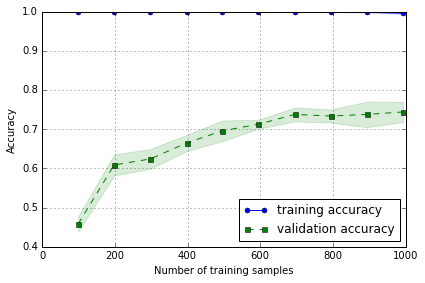

In [33]:
plot_filled(train_scores, test_scores, train_sizes, xlabel='Number of training samples')

Whoa! We are doing something extremely wrong here, the dataset appears to be completely overlearned! Maybe we should try a validation curve to get the right tradeoff in regularization for logistic regression.

In [38]:
if sklearn_version < '0.18':
    from sklearn.learning_curve import validation_curve
else:
    from sklearn.model_selection import validation_curve



param_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0,]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=5,n_jobs=-1)

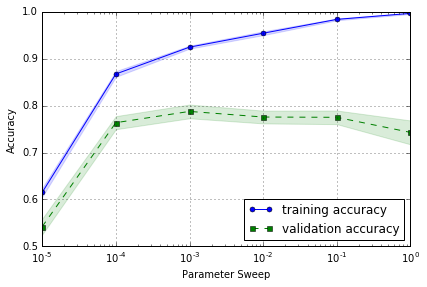

In [39]:
plot_filled(train_scores, test_scores, param_range, xlabel='Parameter Sweep')
plt.xscale('log')
plt.show()

/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


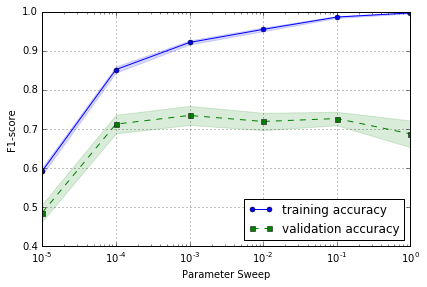

In [43]:
# but how are we doing in terms of precision and recall across the classes?
from sklearn.metrics import make_scorer,f1_score

scorer = make_scorer(f1_score, average='macro')

train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                scoring = scorer,
                param_name='clf__C', 
                param_range=param_range,
                cv=5,n_jobs=-1)

plot_filled(train_scores, test_scores, param_range, xlabel='Parameter Sweep')
plt.xscale('log')
plt.ylabel('F1-score')
plt.show()

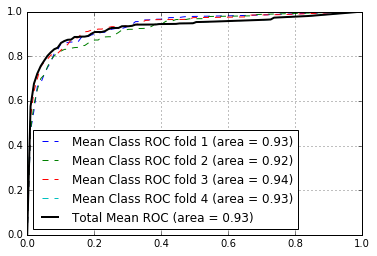

In [49]:
# Great! Its seems we are also maxing out the F1 score, lets go with C==1e-3
from sklearn.metrics import roc_curve, auc
from scipy import interp

K = 4

if sklearn_version < '0.18':
    from sklearn.cross_validation import StratifiedKFold
    kfold = StratifiedKFold(y=y_train, 
                            n_folds=K,
                            random_state=1)
else:
    from sklearn.model_selection import StratifiedKFold
    kfold = StratifiedKFold(n_splits=K,
                            random_state=1).split(X_train, y_train)


mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(kfold):
    probas = pipe_lr.fit(X_train[train],
                         y_train[train]).predict_proba(X_train[test])

    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_train[train])
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_train[test],
                                         probas[:, j],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)
        
    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
    
mean_tpr /= K
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
plt.legend(loc='best')
plt.grid()